_This is a continuation from the first notebook, found [here](../code/Amazon-product-catalog-cleaning-EDA.ipynb)_


# Amazon product ratings predictor

## Imports

In [51]:
#import libraries
#basic ops
import pandas as pd, numpy as np, matplotlib.pyplot as plt, \
       seaborn as sns, re

#other helper functions
from pandasql import sqldf
from math import pi

#show grid on plots
sns.set_style('darkgrid')

#display tables without ellipsis
#pd.set_option('display.max_rows', None)


#NLP

#from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, \
                                            TfidfVectorizer
from sklearn.feature_extraction import text


#modeling
from sklearn.linear_model import LinearRegression, LogisticRegression, \
                                 Ridge, RidgeCV, Lasso, LassoCV

from sklearn.ensemble import RandomForestRegressor, \
                             GradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    cross_val_score

from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, \
                            mean_absolute_error, \
                            mean_absolute_percentage_error, \
                            explained_variance_score, max_error
                            
from sklearn.dummy import DummyRegressor

In [2]:
#read in data
ecom = pd.read_csv('../data/ecom.csv')

In [3]:
ecom.columns

Index(['uniq_id', 'product_name', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'customers_who_bought_this_item_also_bought',
       'description', 'product_information',
       ...
       'amazon_category_and_sub_category_Sports Toys & Outdoor > Racket Games',
       'amazon_category_and_sub_category_Sports Toys & Outdoor > Target Games',
       'amazon_category_and_sub_category_Storage, Cleaning & Ring Sizers > Boxes & Organisers',
       'amazon_category_and_sub_category_Supporters' Gear > Football > Memorabilia & Collectibles',
       'amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate',
       'amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate > Bars > Multipack Bars',
       'amazon_category_and_sub_category_Women > Accessories',
       'amazon_category_and_sub_category_Women > Accessories > Eyewear & Accessories > Sunglasses',
       'amazon_category_and_sub_c

In [4]:
ecom.head()

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,customers_who_bought_this_item_also_bought,description,product_information,...,amazon_category_and_sub_category_Sports Toys & Outdoor > Racket Games,amazon_category_and_sub_category_Sports Toys & Outdoor > Target Games,"amazon_category_and_sub_category_Storage, Cleaning & Ring Sizers > Boxes & Organisers",amazon_category_and_sub_category_Supporters' Gear > Football > Memorabilia & Collectibles,"amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate","amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate > Bars > Multipack Bars",amazon_category_and_sub_category_Women > Accessories,amazon_category_and_sub_category_Women > Accessories > Eyewear & Accessories > Sunglasses,amazon_category_and_sub_category_Women > Tops & T-Shirts,amazon_category_and_sub_category_Worlds Apart > Kid Venture > Kites
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,3.42,5 new,15,1.0,4.9,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,...,0,0,0,0,0,0,0,0,0,0
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,16.99,0,2,1.0,4.0,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,...,0,0,0,0,0,0,0,0,0,0
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,9.99,2 new,17,2.0,3.9,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,...,0,0,0,0,0,0,0,0,0,0
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,39.99,0,1,2.0,0.0,0,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,...,0,0,0,0,0,0,0,0,0,0
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,32.19,0,3,2.0,4.7,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,...,0,0,0,0,0,0,0,0,0,0


### Quick additional text pre-cleaning

In [5]:
#check for nulls now that data has been through and export / import process
ecom.isna().sum().sort_values(ascending=False)

customer_reviews                                                       3
amazon_category_and_sub_category_Worlds Apart > Kid Venture > Kites    0
manufacturer_Halo                                                      0
manufacturer_Hansa                                                     0
manufacturer_Hanna-Barbera                                             0
                                                                      ..
manufacturer_Screenlife                                                0
manufacturer_Scream                                                    0
manufacturer_Scratch                                                   0
manufacturer_Scrabble                                                  0
uniq_id                                                                0
Length: 2916, dtype: int64

In [6]:
ecom['customer_reviews'] = ecom['customer_reviews'].fillna('')

Let's also remove some junk strings to improve our text analysis. (Note: we got these from processing vectorized text first and realizing that a great number of reviews and questions mention time.)

In [7]:
#clean up some custom stop words first, pre-vectorizing (thanks to Gwen for help here):

months = ['jan','january','feb', 'february','mar','march',
          'apr','april','may','jun','june','jul','july','aug','august',
         'sep','sept','september','oct','october','nov','november', 'dec','december']

years= ['2012','2013','2014','2015','2016']

#apply these stop words to reviews

ecom['customer_reviews'] = ecom['customer_reviews'].map(
    lambda x: ' '.join([y for y in x.split() if y.lower() not in months])).map(
    lambda x: ' '.join([y for y in x.split() if y not in years]))

#apply these stop words to cust q's
ecom['customer_questions_and_answers'] = ecom['customer_questions_and_answers'].map(
    lambda x: ' '.join([y for y in x.split() if y.lower() not in months])).map(
    lambda x: ' '.join([y for y in x.split() if y not in years]))

## NLP

Open questions:

* Sentiment of reviews
* Does sentiment correspond to star rating?
* Most interesting question bi-grams and tri-grams
* Most interesting review bi-grams and tri-grams

### Word frequencies

In [8]:
#vectorize text. NOTE: Run the RegEx to remove line breaks from customer review and
#questions columns, first!

#ensure that our inputs are actual strings
ecom['customer_reviews'] = ecom['customer_reviews'].astype('string')
ecom['customer_questions_and_answers'] = ecom['customer_questions_and_answers'].astype(
'string')

#instantiate count vec used for word freq analysis
cvec = CountVectorizer(stop_words='english', max_features=2000) 

#define our columns to use in vectorizer functions
reviews = ecom['customer_reviews'] 
questions = ecom['customer_questions_and_answers']

#function to vectorize
def vectorize(column): #plug in whatever we need to vectorize from df here

    transformed_df = cvec.fit_transform(column)

    transformed_df = pd.DataFrame(
        transformed_df.todense(), columns = cvec.get_feature_names())
    
    #get most important words
    #print('Top 30 most common words in Amazon ' + column)
    
    freq = pd.DataFrame(transformed_df.sum().sort_values(
        ascending=False)[:30], columns=['Frequency'])
    
    return freq

In [9]:
vectorize(reviews) #not sure, why it's still pulling out months after those have been
#cleaned out?..

,Frequency
great,11469
good,11057
jan,9189
dec,7786
stars,7273
nov,5403
feb,5318
quality,4916
oct,4719
bought,4698


In [10]:
vectorize(questions)

,Frequency
does,391
yes,333
hi,293
size,239
just,216
cards,195
box,173
set,158
thanks,156
know,153


Among these, words like 'game', 'old', 'excellent' and 'quality' might be of some interest. However, it's a bit tricky to derive very much meaning from standalone words, so we should look at word groups.

### Bigrams and trigrams

#### Bigrams

In [11]:
#can try to modify stopwords (may not be needed if clean up strings pre-vectorizing)
#my_stop_words = text.ENGLISH_STOP_WORDS.union([2015,'2014'])
#vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

In [12]:
#reviews -- looking for signal!
cvec_2 = CountVectorizer(max_features=2000,
    ngram_range=(2,2),stop_words="english") #need to mod stop words
#by removing months + years -- look out for abbreviations; or do at cleaning step
#see https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn
bigrams = cvec_2.fit_transform(reviews)
bigrams = pd.DataFrame(
    bigrams.todense(), columns=cvec_2.get_feature_names())
bigrams.sum().sort_values(ascending=False).head(15)

year old           2728
good quality       1788
amazon customer    1392
value money        1009
good value          931
great fun           754
really good         623
son loves           593
great value         515
great product       506
old son             476
30 dec              452
great quality       418
fast delivery       416
29 dec              406
dtype: int64

In [13]:
#cust q's
cvec_2 = CountVectorizer(
    max_features = 2000, ngram_range=(2,2),stop_words="english") 
bigrams = cvec_2.fit_transform(questions)
bigrams = pd.DataFrame(
    bigrams.todense(), columns=cvec_2.get_feature_names())
bigrams.sum().sort_values(ascending=False).head(15)

hope helps       115
year old          97
does come         61
don know          34
hi yes            27
yes does          25
kind regards      23
thanks hi         21
sorry don         18
does know         17
don think         15
does include      14
suitable year     13
make sure         13
let know          13
dtype: int64

#### Trigrams

In [14]:
#reviews
cvec_3 = CountVectorizer(max_features=2000,
                         ngram_range=(3,3),stop_words="english") 
trigrams = cvec_3.fit_transform(reviews)
trigrams = pd.DataFrame(trigrams.todense(), columns=cvec_3.get_feature_names())
trigrams.sum().sort_values(ascending=False).head(50)

good value money            408
year old son                371
jan amazon customer         297
dec amazon customer         285
bought year old             264
people following review     239
following review helpful    239
year old daughter           234
great value money           211
year old loves              206
year old grandson           190
nov amazon customer         189
feb amazon customer         145
excellent value money       123
amazon customer jan         117
old son loves               114
present year old            105
oct amazon customer         102
mar amazon customer          95
really good quality          94
bought christmas present     94
10 year old                  93
arrived good time            91
http ecx images              88
amazon com images            88
ecx images amazon            88
images amazon com            88
amazon customer dec          83
500 reviewervine voice       77
jan year old                 76
year old nephew              74
year old

Some possibly interesting bits here are 'year old son', 'bought year old' and 'year old daughter', which tie in well with the kinds of things we saw people shopping for in our dataset. There is also something about the good quality and value for the money, which is promising, and things about something-year old's loving [the product].

In [32]:
#cust q's
cvec_3 = CountVectorizer(max_features=2000,
    ngram_range=(3,3),stop_words="english") 
trigrams = cvec_3.fit_transform(questions)
trigrams = pd.DataFrame(trigrams.todense(), columns=cvec_3.get_feature_names())
trigrams.sum().sort_values(ascending=False).head(25)

sorry don know           15
suitable year old        11
hope helps does           8
does item come            7
www amazon uk             6
does come pump            5
bought year old           5
hot wheels cars           5
http www amazon           5
knight castle model       5
mega metagross ex         5
amazon uk gp              5
year old boy              5
official rainbow loom     5
year old loves            5
year old son              5
year old year             5
old year old              5
hi thanks question        5
halloi think 10           4
enjoy nice shopping       4
does include binder       4
ex included enjoy         4
think 10 years            4
10 years parts            4
dtype: int64

"Suitable year old" is actually revealing about a top concern, as are questions about parts -- so this is helpful.

### Customer review sentiment analysis

In [33]:
#First, convert to a list of strings; full reference in this entire section to the sentiment analysis lesson from Heather Robbins
corpus = list(reviews)
while("" in corpus) : corpus.remove("") #from: https://www.geeksforgeeks.org/python-remove-empty-strings-from-list-of-strings/
print(len(corpus))
corpus[:5]

9979


["Worth Buying For The Pictures Alone (As Ever) 4.0 6 By Copnovelist on 6 Part of the magic for me growing up as a boy was to buy (or be given) the new Hornby catalogue every year, even if it included 90% of the same products as the previous year. I've still got my old ones dating back to the 70s and 80s somewhere. These days the catalogue is especially informative in that it tells you the vintage of the rolling stock which is useful if you are dedicating your railway to one particular era and train company. Amazing detail fabulous photography. 5.0 11 By richard on 11 Amazing detail, every credit to the photographer in this book, a worthy reference manual, as well as a sales brochure. even if you only have a passing interest in the hobby you will be transported to another time when we were all younger and in awe of the big trains. 'Great Purchase' 5.0 23 By Pinkhandbag on 23 This was purchased on behalf of my Dad. He is always asking me to look up 00 gauge engines online, so this has b

In [17]:
#sentiment analysis
#instantiate VADER
vader = SentimentIntensityAnalyzer()

#loop through reviews
sentiment = []    

for review in corpus:
    scores = vader.polarity_scores(review)
    scores['customer_reviews'] = review
    sentiment.append(scores)

sentiment_df = pd.DataFrame(sentiment)

#reset indices to match
ecom.reset_index(inplace=True)
sentiment_df.reset_index(inplace=True)

In [18]:
#set target to plot sentiment
sentiment_df['target'] =ecom['average_review_rating']

#Plot the average positivity, negativity and compound scores for target
#plt.figure(figsize=(20,12));
sentiments=sentiment_df.groupby(
    'target').mean()[['pos', 'neg', 'compound', 'neu']]

sentiments

,pos,neg,compound,neu
target,,,,
0.0,0.251251,0.020827,0.797530,0.727914
2.3,0.147000,0.086000,0.873500,0.767000
3.0,0.130800,0.027200,0.720760,0.842200
3.3,0.192500,0.031500,0.965550,0.776000
3.6,0.290333,0.039000,0.825567,0.670667
3.7,0.124000,0.036500,0.499500,0.839500
3.8,0.212000,0.030000,0.990500,0.758000
3.9,0.198714,0.061429,0.959229,0.739857
4.0,0.239160,0.024778,0.816897,0.736063


#### Sentiment plot

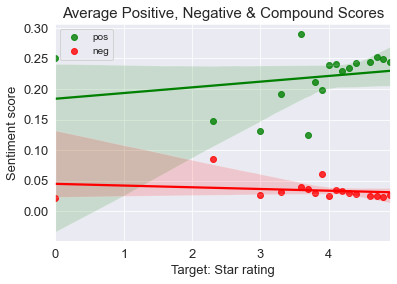

In [19]:
#sentiments.plot(kind='line'); #help from Gwen Rathgeber on this plot

sns.regplot(
    data=sentiments, x=sentiments.index, y = 'pos', color = 'green', 
    label = 'pos')

sns.regplot(
    data=sentiments, x=sentiments.index, y = 'neg', color = 'red', 
    label = 'neg')


plt.title('Average Positive, Negative & Compound Scores', size = 15);
plt.xticks(size=13);
plt.yticks(size=13);
plt.ylabel('Sentiment score', size=13);
plt.xlabel('Target: Star rating', size=13);
plt.savefig('../assets/sentiment.jpg');
plt.legend();

We can actually see a linear relationship here!

In [20]:
#explore specific negative terms!!
#get sentiment_df columns; then filter on the 'neg' column - only if time

## Modeling - regression

Since our target, average ratings, is continous and known, we will use supervised regression modeling.

Our hypothesis is that text may be a fairly weak predictor of the rating. However, we are hoping to come across some speficic negative and non-neutral words that can help us explain some of the lower side of the ratings.

We should also remember that not every product that's rated may necessarily come with a written review. Lastly, some products may not have any rating.

### Prepare text for modeling

In [21]:
#instantiate cvec
cvec_modeling = CountVectorizer(
    stop_words = 'english', 
    max_features = 2_000, #init guess for efficiency; + use grid search? (optional)
    ngram_range=(1, 5), #from Gwen: you give ngram_range a tuple which is a range, 
    #so (2,5) is two-to-five-word combination
) #tinker w/ max features dep. on how long runs

It's time time define our features set. We are using sentiment, our text, our categorized columns and all the numeric inputs including price.

In [22]:
#new word array w/ cvec transform; set X and y
#consider tfid vectorizer
cvec_df = cvec_modeling.fit_transform(sentiment_df['customer_reviews'])

cvec_df=pd.DataFrame(
    cvec_df.todense(), columns = cvec_modeling.get_feature_names())

features=pd.concat([cvec_df, sentiment_df],axis=1)#, ignore_index=True)

X = features.drop(
    columns = ['target', 'customer_reviews','index']) #been vectorized; drop unnecessary index we created on concat

feature_names = X.columns
#X = np.array(X) 

y = (sentiment_df['target']) #np.array

features.shape

(9979, 2007)

In [23]:
# Saving feature names for later use - ref: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
feature_list = list(features.columns)
# we may or may not want to do this for vectorized text!

Let's split off our training and prediction data now.

In [24]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, random_state = 42)

In [25]:
X_train.shape

(7484, 2004)

In [26]:
y_train.shape

(7484,)

In [27]:
X_test.shape

(2495, 2004)

In [28]:
y_test.shape

(2495,)

### Fit RandomForest Regressor

Let's first understand our baseline.

For regression problems, it is the mean of our target -- in this case, the average star rating:

In [29]:
y_test.mean()

2.1096192384769554

In [35]:
#instantiate

#note: scaling is not required for RandomForest models

rf_regressor = RandomForestRegressor(
    n_estimators = 500, random_state = 42, ccp_alpha=.1) #, max_features = 5000)

#help our trees with search / split criteria and to make a decision!

#1. can try to reduce number of max_features (trying it here)

#2. can try something other than the default min_samples_split=2

#3. perf initial grid search / prune trees - tune model

#4. set ccp_alpha=.1 (trying it here)

#fit
rf_regressor.fit(X_train, y_train)

#get target preds
rf_preds = rf_regressor.predict(X_test)  

#### Evaluation

Given that we are dealing with some 0's or near 0's, some metrics will not work as well as others (as an example, mean absolute percentage error).

From the [docstring](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics):

>"The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. Some of those have been enhanced to handle the multioutput case: mean_squared_error, mean_absolute_error, explained_variance_score and r2_score.
>These functions have an multioutput keyword argument which specifies the way the scores or losses for each individual target should be averaged."

In [36]:
#calculate r sq using sci-kit learn
print(f'The R squared using the Random Forest model on our data is '\
      f'{round(r2_score(y_test, rf_preds),4)}.')

The R squared using the Random Forest model on our data is 0.0282.


In [37]:
#calculate RMSE using sci-kit learn
RMSE = mean_squared_error(y_test, rf_preds)

print(f'The Root Mean Squared Error on our Random Forest model is '\
     f'{round(RMSE,4)}.')

The Root Mean Squared Error on our Random Forest model is 4.5975.


In [38]:
#from ref: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Calculate the absolute errors
errors = abs(rf_preds - y_test)

# Print out the mean absolute error (mae)
print(f'The Mean Absolute Error on our Random Forest model is '\
      f'{round(np.mean(errors), 2)} stars.')

#confirm mean abs error calc using sci-kit learn:
mean_absolute_error(y_test, rf_preds).round(4)

The Mean Absolute Error on our Random Forest model is 2.1 stars.


2.0985

Let's recall the meaning of these metrics, to help with interpretation (from the documentation):

>"The r2_score function computes the coefficient of determination, usually denoted as R². It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance."

The R-squared score is very, very poor, indicating that very little connection indeed exists between our features and target.


Further:

>"The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or -norm loss."

Whereas:

>"The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss."

Our mean absolute error indicates that ___, and the mean squared error that ___.


Let's look at some additional metrics.

In [39]:
#from https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

#calculate explained variance regression score
#per docstring: best possible score is 1.0, lower values are worse

exp_var = explained_variance_score(
    y_test, rf_preds, multioutput='variance_weighted')

print(
    f'The explained variance score, using the Random Forest model' \
f' is {round(exp_var,4)}.')

#calculate max error
max_err = max_error(y_test, rf_preds)
      
print(
    f'The max error on the Random Forest model is {round(max_err,2)}.')

The explained variance score, using the Random Forest model is 0.0282.
The max error on the Random Forest model is 3.12.


The explained variance is pretty horrific.

As for the max score, we see that the error once again is quite high, which only proves that trying to use our training data to predict target performance is going to be highly unreliable here.

Recall:

>"The max_error function computes the maximum residual error , a metric that captures the worst case error between the predicted value and the true value. In a perfectly fitted single output regression model, max_error would be 0 on the training set and though this would be highly unlikely in the real world, this metric shows the extent of error that the model had when it was fitted."

#### Feature importances

In [40]:
#residual plots

In [41]:
#derive feature importances -- this is the bulk of the interpretation here
#look at word pairs
#look at project 4 (Helen Meigs's work) - https://git.generalassemb.ly/rileyrobertson/project_4-hackathon/blob/main/helen/modeling_hm.ipynb
#consider as spider plot! (ref. own work in FB lab)

#d = {'Feature Name':rf_regressor.best_estimator_.named_steps['tf'].get_feature_names(),
     'Coef':list(rf_regressor.best_estimator_.named_steps['mnb'].coef_.T)}

#fi = pd.DataFrame(d)

#rf_coefs = fi.sort_values(by=['Coef'], ascending = False).head(500)

### Fit regularized LR


Our Random Forest choked quite a bit on the multi-dimensionality and issues with overfitting.

Let's try it with a regularized model. With a regularized model, we will solve the earlier seen issues with line assumption violations. However, we may lose some interpretability.

Also recall:

>"Lasso regression stands for Least Absolute Shrinkage and Selection Operator. It adds penalty term to the cost function. The difference between ridge and lasso regression is that it tends to make coefficients to absolute zero as compared to Ridge which never sets the value of coefficient to absolute zero." [source](https://www.geeksforgeeks.org/lasso-vs-ridge-vs-elastic-net-ml/#:~:text=Lasso%20regression%20stands%20for%20Least,term%20to%20the%20cost%20function.&text=The%20difference%20between%20ridge%20and,of%20coefficient%20to%20absolute%20zero.)

Essentially, we hope get rid of many of the noisy features that may have contributed to the overfitting we saw with Random Forest.

In [50]:
#lasso -- tune alpha param / set up grid search
#some reference to Amy Giver's code: https://git.generalassemb.ly/agiver/project_2/blob/friday/code/gridsearch.ipynb

#instantiate scaler
ss = StandardScaler()

#apply scaler
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

#define hyperparams for model tuning

lasso_params = {
    'alpha': [.01, .1, 1],
    'normalize': [1], #this is to help with convergence:
    #from https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge
    'max_iter': [10_000],
    'tol': [1] 
}

#instantiate grid search
lasso_gs = GridSearchCV(Lasso(), lasso_params, cv=5, verbose=1)

#fit grid search
lasso_gs.fit(Xs_train, y_train)

#get best score
print(lasso_gs.best_score_)

#get best params
print(lasso_gs.best_params_)

#score train and test
lasso_gs.score(Xs_train, y_train), lasso_gs.score(Xs_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
-0.0004123741573871964
{'alpha': 0.01, 'max_iter': 10000, 'normalize': 1, 'tol': 1}


(0.0, -6.162922526264936e-05)

#### Evaluation and interpretation

Without any tuning, the scores we get on the Lasso model are:

(0.09656655494531563, 0.0570325335256735) for train and test, respectively.

With tuning, these become even worse.

In [ ]:
#coefs / plots

### Gradient Boosting Regressor


Since our Random Forest and regularized linear regression performed less than stellarly, we will attempt one additional model.

A gradient boost regressor starts out as a weak learner but improves as it lears, as opposed to a forest model, which takes all features into account right away, to form an opinion. (Per Heather Robbins, General Assembly data science immersive instructor.)

In [ ]:
#from the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
#note: scaling not required for Gradient Boosting regression models: https://quant.stackexchange.com/questions/4434/gradient-tree-boosting-do-input-attributes-need-to-be-scaled

#instantiate
booster = GradientBoostingRegressor(random_state=0)

#fit on training data
booster.fit(X_train, y_train) #not on scaled

#predict target
booster.predict(X_test)

#get R2 score
booster.score(X_test, y_test)

#### Evaluation and interpretation

In [ ]:
#pull out coefs!

### SVM Regressor

The Support Vector Machine algorithm utilizes distances from some plane to determine fit.

>"Our objective, when we are moving on with SVR, is to basically consider the points that are within the decision boundary line. Our best fit line is the hyperplane that has a maximum number of points." [source](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/).

Several advantages of an SVM model are the ability to use "kernel tricks" to add new dimensions in order to find a hyperplane of fit; it also, natually, deals well with multidimensionality and non-linearity. In addition, the model can handle outliers. _Note: some of this is based on material from Sophie "Sonia" Tabac, a General Assembly data science immersive lecturer._

In [56]:
#ref: https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/
#note: grid search advised, to find optimal params due to multiple dims
#note: must use standard-scaled features, since dealing w/ distances

#set up grid search
svr_params = {
   # 'kernel': ['rbf'], #default; see doc here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
  #  'gamma': [‘scale’, ‘auto’],
    'C': [.01, .1, 1],
    'tol': [1, .1],
  #  'max_iter': [10],
    'epsilon' : [.1, .2]
}


#instantiate and fit regressor
#svm_regressor = SVR() 
#svm_regressor.fit(Xs_train, y_train)

#using gs

#instantiate grid search
svr_gs = GridSearchCV(SVR(), svr_params, cv=5, verbose=1)

#fit grid search
svr_gs.fit(Xs_train, y_train)

#get best score
print(svr_gs.best_score_)

#get best params
print(svr_gs.best_params_)


#generate new target predictions
svm_preds = svr_gs.predict(Xs_test) #svm_regressor.predict(Xs_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
-0.08410657428422952
{'C': 1, 'epsilon': 0.2, 'tol': 0.1}


#### Evaluation

Recall that:

>"In linear SVM, the result is a hyperplane that separates the classes as best as possible. The weights represent this hyperplane, by giving you the coordinates of a vector which is orthogonal to the hyperplane - these are the coefficients given by svm. coef_." [source](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights)

In [ ]:
#get R2 score for train and test
svr_gs.score(Xs_train, y_train), svr_gs.score(Xs_test, y_test)

In [ ]:
#pull out coefs only for best model!!

## Conclusion and next steps

We approached a data set with the apptempt to use text data to predict star ratings of an Amazon product.

In doing so, we ran into a few challenges with dimensionality.
In addition, if we consider the complexity of the problem we've set out to solve, instinctively, predicting an exact numeric average for a product, down to decimal points, is exceedingly hard. In the future, we may try to re-frame the problem as a classification problem and attempt this exercise again on more vague and perhaps subjective targets, such as classifying a score as either "poor" (if it is below 3 out of 5 stars), "good or better" (if it's 4 stars or above) or "neutral".

In terms of data, we should mention a bit about potential bias as well. Because the sample was obtained from someone else's scaping results, we are a bit removed from the original source and cannot vouch for 100% accuracy of the data or the extraction methods.

One piece missing, for example, is the dates of the purchases (or direct purchase data) or of the reviews themselves; as a result, we are relying on extrapolating popularity from the number of reviews, without any idea of the freshness or recency of the data.

In addition, the original prices were in British pounds, so the data may be biased or skewed to a particular region; and the categories appear to may have been filtered down to only games and toy product related, which gives us at best a subset of customer purchases and, thus, possible insights.

Further, because no purchase data or product listing age information are available, rather than deducing sales, we can really only look at identifying general product popularity. We must be careful to account for nuances, such as the freshness of a product listing. We do, however, assume a near direct proportion between the number of reviews and a product's purchases; that is to say, each review must come from a purchase (so there are at least that many) because of Amazon's product verification process (i.e., Amazon only allows customer reviews from validated purchases). Therefore, even our few outliers with 1,000+ ratings are presumed to be legitimate purchases.

Lastly, a word of caution must be noted on ratings overall. While the subject of scrutiny of papers beyond our scope, ratings are inherently subjective due to their design, and some customers may be confused about how to use them (e.g., think that 1 star is the best rating). We must ignore these kinds of nuances, without the ability here to do qualitative research to question the validity of each rating, but one way to get at this is to ensure, for example, that the sentiment -- e.g. a positive review -- actually corresponds with the rating, e.g. a positive rating (4 stars or better) in the case of a positive review, which we attempt to do with the sentiment analysis tools at our disposal.